In [1]:
__author__ = 'pratyush'
import requests
import json
import os
import modules.config as config
from time import sleep
from requests.auth import HTTPBasicAuth
from ibm_watson import DiscoveryV1
from pprint import pprint
import modules.discovery_helper as dh_help
import modules.common_helper as cm_help
import sys
import pandas as pd
import modules.config as config
import math
import re
import hashlib
import unicodedata
from bs4 import BeautifulSoup 
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [2]:
all_params = cm_help.get_params()

In [3]:
def discovery_init(COLLECTION_NAME=config.DISCOVERY_COLLECTION_NAME,default=all_params['discovery']['default']):
    response = {}
    
    discovery_param = all_params['discovery']
    # default = 
    authenticator = IAMAuthenticator(apikey=discovery_param[default]['apikey'])
    endurl = "https://gateway.watsonplatform.net/discovery/api"
    discovery = DiscoveryV1(
        version=discovery_param[default]['version'],
        authenticator = authenticator)
    iam_apikey=discovery_param[default]['apikey'],
    url=discovery_param[default]['url']    
    if default =="r3":
        discovery.set_service_url(discovery_param[default]['url'])

    environments = discovery.list_environments().get_result()
    # print(json.dumps(environments, indent=2))
    print("Discovery instance loaded "+default)
    js = json.dumps(environments)
    jres = json.loads(js)
    # print(jres['environments'][1]['environment_id'])
    env_id = jres['environments'][1]['environment_id']
    collections = discovery.list_collections(env_id).get_result()
    cols = json.dumps(collections, indent=2)
    colres = json.loads(cols)

    #print(colres['collections'])
    for item in colres['collections']:
        if item['name']== COLLECTION_NAME:
            print('COLLECTION ID:', item['collection_id'], 'COLLECTION NAME:', item['name'])
            col_id = item['collection_id']
    response['env_id'] = env_id
    response['col_id'] = col_id
    response['discovery'] = discovery
    return response

In [4]:
discovery_config = discovery_init(COLLECTION_NAME='Naviga1',default="r3")

Discovery instance loaded r3
COLLECTION ID: ec586f27-f848-40b7-99af-dab80a43b248 COLLECTION NAME: Naviga1


In [6]:
offset = 0
count = 99
reqparams = {'offset':offset,'count':count}
reqparams['aggr'] = 'term(html,count:600000)'
discovery_data = dh_help.getDiscoveryData(discovery_config,reqparams)

offset in query = 0


In [53]:
 discovery_data["results"][0]

{'id': '371ff4b9-f4ad-4f60-8466-9daa150c405f',
 'result_metadata': {'score': 1},
 'resourceID': '202006050252AMSPIDERAMC_USR__Etvv6_W4_5a361c9fa648a92439a57a711c4f0cd3_1',
 'enriched_description': {'semantic_roles': [],
  'relations': [],
  'keywords': [{'text': 'Die Nähe zu Marsch',
    'relevance': 0.994205,
    'count': 1},
   {'text': 'und Ostsee', 'relevance': 0.574929, 'count': 1},
   {'text': 'Nord', 'relevance': 0.554564, 'count': 1},
   {'text': 'Watt und Meer prägen den Charme Husums',
    'relevance': 0.223553,
    'count': 1},
   {'text': 'Geest', 'relevance': 0.2105, 'count': 1},
   {'text': 'Urlaubsorte', 'relevance': 0.19886, 'count': 1}],
  'entities': [{'count': 1,
    'text': 'Nord- und Ostsee',
    'relevance': 0.973716,
    'type': 'Location',
    'disambiguation': {'subtype': ['City']}},
   {'type': 'Facility',
    'text': 'den Charme Husums',
    'relevance': 0.72053,
    'count': 1}]},
 'description': 'Die schönsten Urlaubsorte an Nord- und Ostsee. Die Nähe zu Ma

In [75]:
data_ner = json.load(open("JSON_Spacy.json"))

In [76]:
data_ner = data_ner["All_sp"][:]

In [74]:
data_ner

[{'id': '167424f8-ca7f-4224-a00b-a54a5a7766c7',
  'CARDINAL': ['138',
   'three',
   'nine',
   '27.1',
   '20',
   '100',
   '2020',
   'eight',
   '6',
   '50\x9640\x9690',
   '30',
   '9',
   'One',
   'five',
   '12',
   '146',
   'one',
   'six',
   'seven',
   '33',
   '5',
   '10',
   '38,387',
   'two',
   'four',
   'one half',
   '19.5',
   '50.4',
   '11',
   '181',
   '25.68'],
  'ORG': ["O'Neal",
   'Russel',
   'MJ',
   'NBA Finals',
   'All-NBA First Team',
   'the Dream Team',
   'NBA',
   'the Orlando Magic',
   'Spurs',
   'Lakers',
   'Russel Westbrook',
   'Ervin',
   'Bulls',
   "the Chicago Bulls' dynasty",
   'the Houston Rockets',
   'Washington Wizards',
   'the Miami Heat',
   'Olajuwon',
   'UCLA',
   'the Boston Celtics',
   'ESPN',
   'Basketball'],
  'DATE': ['1995',
   '1994',
   '13 seasons',
   'the decade',
   'the 80s and 90s',
   'Sunday',
   '1968',
   '17 seasons',
   'January of this year',
   '17440',
   'his years',
   'the first five months',
 

In [79]:
result = []
offset = 0
count = 1

# while offset<=10000:
#     count = 100
#     reqparams = {'offset':offset,'count':count}
#     discovery_data = dh_help.getDiscoveryData(discovery_config,reqparams)
#     offset+=100
#     ent = discovery_data2["results"][0]["enriched_text"]["entities"]
for i in range(10000):
    res={}

    #doc = discovery_data2["results"]
    res["id"]= data_ner[i]['id']
    reqparams = {'offset':offset,'count':count}
    reqparams['filters']='id::'+data_ner[i]['id']
    discovery_data2 = dh_help.getDiscoveryData(discovery_config,reqparams)



    source = discovery_data2["results"][0]['html']
    batRegex = re.compile(r'(.<[a-zA-Z]*[^>]*>(.+?)</[a-zA-Z]*>)')

    lists = re.findall(batRegex,source)
    len_ = len(lists)
    for i in range(len_):
        lists[i] = list(lists[i])

    regex = re.compile(r'\svalue="(.*?)"')
    subst = ''
    for i in range(len_):
        bregex = re.findall(regex,lists[i][0])
        if(len(bregex)!=0):
            lists[i][0] = lists[i][0].replace(bregex[0], subst)

    regex = re.compile(r'\sidsrc="(.*?)"')
    for i in range(len_):
        bregex = re.findall(regex,lists[i][0])
        if(len(bregex)!=0):
            lists[i][0] = lists[i][0].replace(bregex[0], subst)

    regex = re.compile(r'\shref="(.*?)"')
    for i in range(len_):
        bregex = re.findall(regex,lists[i][0])
        if(len(bregex)!=0):
            lists[i][0] = lists[i][0].replace(bregex[0], subst)


    for i in range(len_):
        lists[i][0]=lists[i][0].rsplit('/',1)
        lists[i][0][1]=lists[i][0][1].rsplit('>',1)
        keyword = lists[i][0][1][0]
        value = lists[i][1]

        if keyword in res:
            if value not in res[keyword]:
                res[keyword].append(value)       
        else:
            res[keyword] = [value]

    result.append(res)

offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0
offset in query = 0


[{'id': '167424f8-ca7f-4224-a00b-a54a5a7766c7',
  'person': ['Kobe Bryant',
   'LeBron James',
   'Michael Jordan',
   'Bill Russel',
   'Robert Horry',
   'Scottie Pippen',
   'Magic Johnson',
   'Kareem Abdul-Jabbar',
   'Oscar Robertson',
   'Russel Westbrook',
   'Hakeem Olajuwon',
   'Larry Bird',
   'Larry Legend',
   "Shaquille O'Neal",
   'Ervin "Magic" Johnson',
   'Wilt Chamberlain',
   "Wilt Chamberlain's",
   'LeBon James',
   'Kareem Abdul Jabar',
   'John Wooden',
   'Lew Alcindor',
   'Babe Ruth'],
  'org': ["Chicago Bulls'",
   "ESPN's",
   'Boston Celtics',
   'Houston Rockets',
   'Orlando Magic',
   'Miami Heat',
   'UCLA',
   'Chicago Bulls',
   'Washington Wizards'],
  'location': ['Mount Rushmore', 'Los Angeles']},
 {'id': '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
  'location': ['Des Plaines American Legion Post 36',
   'Edward Hotel',
   'Mannheim Road',
   'Rosemont',
   'Park Ridge',
   'Chicago'],
  'chron': ['Aug. 1', 'March 21, 2021', 'Friday, May 29'],
  'per
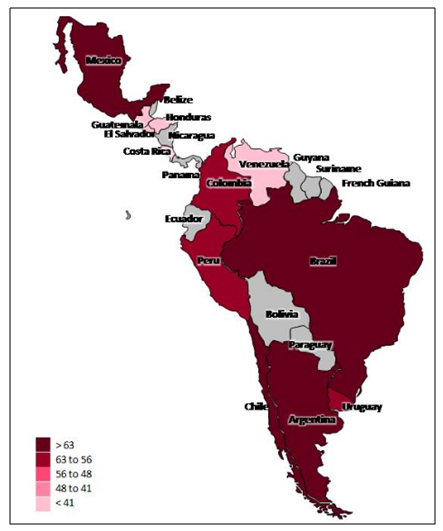
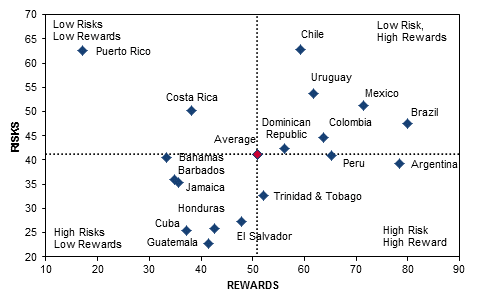
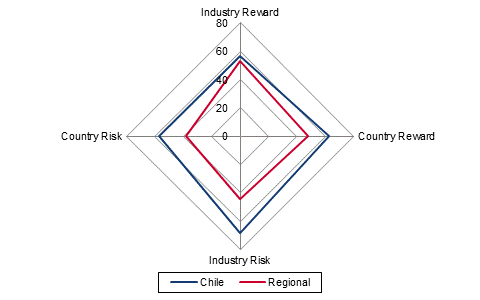

In [80]:
result

In [100]:
json.dump(result,open("norm_html.json",'w'))

In [48]:
result = json.load(open("norm_html.json"))

[{'id': '167424f8-ca7f-4224-a00b-a54a5a7766c7',
  'person': ['Kobe Bryant',
   'LeBron James',
   'Michael Jordan',
   'Bill Russel',
   'Robert Horry',
   'Scottie Pippen',
   'Magic Johnson',
   'Kareem Abdul-Jabbar',
   'Oscar Robertson',
   'Russel Westbrook',
   'Hakeem Olajuwon',
   'Larry Bird',
   'Larry Legend',
   "Shaquille O'Neal",
   'Ervin "Magic" Johnson',
   'Wilt Chamberlain',
   "Wilt Chamberlain's",
   'LeBon James',
   'Kareem Abdul Jabar',
   'John Wooden',
   'Lew Alcindor',
   'Babe Ruth'],
  'org': ["Chicago Bulls'",
   "ESPN's",
   'Boston Celtics',
   'Houston Rockets',
   'Orlando Magic',
   'Miami Heat',
   'UCLA',
   'Chicago Bulls',
   'Washington Wizards'],
  'location': ['Mount Rushmore', 'Los Angeles']},
 {'id': '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
  'location': ['Des Plaines American Legion Post 36',
   'Edward Hotel',
   'Mannheim Road',
   'Rosemont',
   'Park Ridge',
   'Chicago'],
  'chron': ['Aug. 1', 'March 21, 2021', 'Friday, May 29'],
  'per
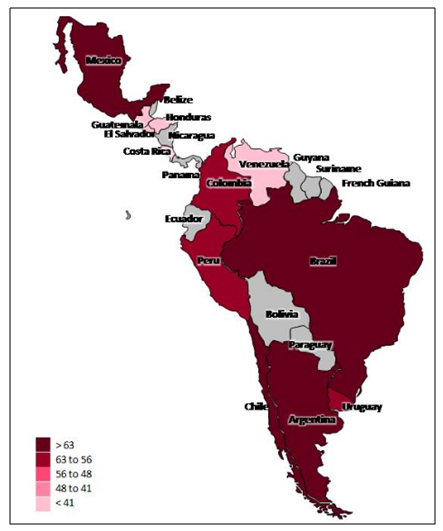
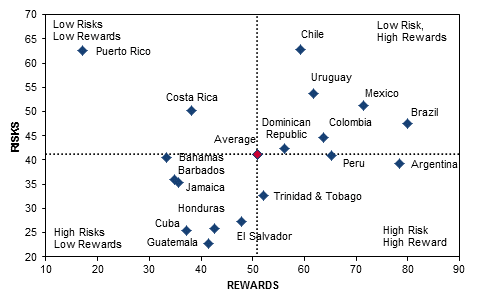
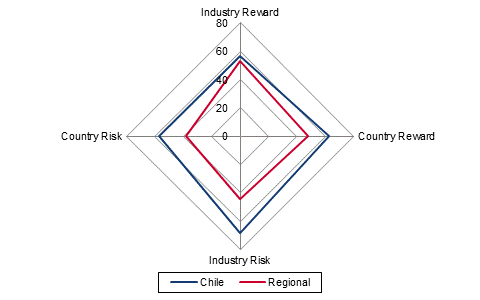

In [49]:
result

In [50]:
dic = {'person':[],'org':[],'location':[],'person_id':[],'org_id':[],'location_id':[]}

In [51]:
req = ['person','org','location','person_id','org_id','location_id']

In [52]:
for item in result:
    #print(item['id'])
    #dic['org_id'].append(item['id'])
    
    for key,value in item.items():
        start = 0
        end=36
        if key in req:
            dic[key].extend(value)
        if key == 'person':
            for i in range(len(item['person'])):
                dic['person_id'].append(item['id'])
        if key == 'org':
            for i in range(len(item['org'])):
                dic['org_id'].append(item['id'])
        if key == 'location':
            for i in range(len(item['location'])):
                dic['location_id'].append(item['id'])

In [46]:
"".join(dic['org_id'][0:36])

'167424f8-ca7f-4224-a00b-a54a5a7766c7'

In [53]:
len(dic["person"])

40489

In [54]:
len(dic["org"])

27853

In [55]:
len(dic["location"])

39971

In [58]:
len(dic["person_id"])

40489

In [59]:
new_dict = {'person':[],'org':[],'location':[],'person_id':[],'org_id':[],'location_id':[]}

In [60]:
per_set = set()
for i in range(len(dic["person"])):
    if dic["person"][i] not in per_set:
        per_set.add(dic["person"][i])
        new_dict["person"].append(dic["person"][i])
        new_dict["person_id"].append(dic["person_id"][i])

In [196]:
dic["person"] = set(dic["person"])
dic["person"] = list(dic["person"])

In [65]:
len(new_dict["person"])

27906

In [66]:
new_dict["person"]

['Kobe Bryant',
 'LeBron James',
 'Michael Jordan',
 'Bill Russel',
 'Robert Horry',
 'Scottie Pippen',
 'Magic Johnson',
 'Kareem Abdul-Jabbar',
 'Oscar Robertson',
 'Russel Westbrook',
 'Hakeem Olajuwon',
 'Larry Bird',
 'Larry Legend',
 "Shaquille O'Neal",
 'Ervin "Magic" Johnson',
 'Wilt Chamberlain',
 "Wilt Chamberlain's",
 'LeBon James',
 'Kareem Abdul Jabar',
 'John Wooden',
 'Lew Alcindor',
 'Babe Ruth',
 'Tom Strossner',
 'Mike Morath',
 'Greg Abbott',
 'Betsy DeVos',
 'Marshal Yanda',
 'Chris Doyle',
 'Alan Faneca',
 'Dennis Rodman',
 'Jerry Krause',
 'Phil Jackson',
 'Isiah Thomas',
 'Karl Malone',
 'Jerry Sloan',
 'Kevin Dresser',
 'Julien Broderson',
 'Hilton (Coliseum)',
 'Kyle Hendricks',
 'Stephen Strasburg',
 'Luis Castillo',
 'Chris Paddack',
 'Tommy Kahnle',
 'Rosie Soria',
 'Bonnie Soria Najera',
 "Leo Soria's",
 'Eldona Janutolo',
 'George Aiken',
 'Lyndon Johnson',
 'Michael Sherman',
 'Brenda Torpy',
 'Eileen Peltier',
 'Nancy Owens',
 'Andrew Winter',
 'Elizabet

In [67]:
org_set = set()
for i in range(len(dic["org"])):
    if dic["org"][i] not in org_set:
        org_set.add(dic["org"][i])
        new_dict["org"].append(dic["org"][i])
        new_dict["org_id"].append(dic["org_id"][i])

In [68]:
print(len(new_dict["org"]),len(new_dict["org_id"]))

15095 15095


In [70]:
new_dict["org_id"]

['167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 '70ebe48c-a75d-4236-9ed6-4af0d8e1a421',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '92123e9a-a03a-48f1-9f57-59319648b9a0',
 '92123e9a-a03a-48f1-9f57-59319648b9a0',
 'a1433e93-fa9b-

In [192]:
dic["org"] = set(dic["org"])

In [194]:
dic["org"] = list(dic["org"])

In [195]:
len(dic["org"])

15095

In [71]:
loc_set = set()
for i in range(len(dic["location"])):
    if dic["location"][i] not in loc_set:
        loc_set.add(dic["location"][i])
        new_dict["location"].append(dic["location"][i])
        new_dict["location_id"].append(dic["location_id"][i])

In [73]:
print(len(new_dict["location"]),len(new_dict["location_id"]))

13979 13979


In [75]:
new_dict["location_id"]

['167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '167424f8-ca7f-4224-a00b-a54a5a7766c7',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '7185ebf3-fa27-4fdc-a9fd-2011165a8603',
 '16601478-ebd3-4b55-bd54-e292865696e1',
 '16601478-ebd3-4b55-bd54-e292865696e1',
 '16601478-ebd3-4b55-bd54-e292865696e1',
 '16601478-ebd3-4b55-bd54-e292865696e1',
 '16601478-ebd3-4b55-bd54-e292865696e1',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 'a6f63029-6c69-49ea-a0dc-a5c7e85f55fb',
 '70ebe48c-a75d-4236-9ed6-4af0d8e1a421',
 '70ebe48c-a75d-4236-9ed6-4af0d8e1a421',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-4684-9c75-612abe362a84',
 '172ac60b-3611-

In [198]:
dic["location"] = set(dic["location"])
dic["location"] = list(dic["location"])

In [199]:
len(dic["location"])

13979

In [80]:
nav = pd.read_excel("Naviga_Entity_Extraction_v001.xlsx", sheet_name="Naviga")

In [81]:
nav = pd.DataFrame(nav)

In [82]:
nav

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5]
Index: []

In [83]:
# nav["Person_Naviga"] = dic["person"]
# nav["Company_Naviga"] = dic["org"]
# nav["Location_Naviga"] = dic["location"]
df1 = pd.DataFrame(new_dict["person"],columns=["Person_Naviga"])
df2 = pd.DataFrame(new_dict["person_id"],columns=["Person_ID"])
df3 = pd.DataFrame(new_dict["org"],columns=["Company_Naviga"])
df4 = pd.DataFrame(new_dict["org_id"],columns=["Company_ID"])
df5 = pd.DataFrame(new_dict["location"],columns=["Location_Naviga"])
df6 = pd.DataFrame(new_dict["location_id"],columns=["Location_ID"])
df_doc = pd.concat([df1,df2,df3,df4,df5,df6], ignore_index=True, axis=1)
nav = nav.append(df_doc)

In [84]:
nav.head()

0                                     1                2  \
0     Kobe Bryant  167424f8-ca7f-4224-a00b-a54a5a7766c7   Chicago Bulls'   
1    LeBron James  167424f8-ca7f-4224-a00b-a54a5a7766c7           ESPN's   
2  Michael Jordan  167424f8-ca7f-4224-a00b-a54a5a7766c7   Boston Celtics   
3     Bill Russel  167424f8-ca7f-4224-a00b-a54a5a7766c7  Houston Rockets   
4    Robert Horry  167424f8-ca7f-4224-a00b-a54a5a7766c7    Orlando Magic   

                                      3                                    4  \
0  167424f8-ca7f-4224-a00b-a54a5a7766c7                       Mount Rushmore   
1  167424f8-ca7f-4224-a00b-a54a5a7766c7                          Los Angeles   
2  167424f8-ca7f-4224-a00b-a54a5a7766c7  Des Plaines American Legion Post 36   
3  167424f8-ca7f-4224-a00b-a54a5a7766c7                         Edward Hotel   
4  167424f8-ca7f-4224-a00b-a54a5a7766c7                        Mannheim Road   

                                      5  
0  167424f8-ca7f-4224-a00b-a54a5a7766c7  
1  167424f8-ca7f-4224-a00b-a54a5a7766c7  
2  7185ebf3-fa27-4fdc-a9fd-2011165a8603  
3  7185ebf3-fa27-4fdc-a9fd-2011165a8603  
4  7185ebf3-fa27-4fdc-a9fd-2011165a8603

In [85]:
nav = nav.fillna("")
nav = nav.rename(columns={0: "Person_Naviga", 1: "Person_ID", 2:"Company_Naviga", 3:"Company_ID", 4:"Location_Naviga",5:"Location_ID"})

In [86]:
nav.head()


Person_Naviga                             Person_ID   Company_Naviga  \
0     Kobe Bryant  167424f8-ca7f-4224-a00b-a54a5a7766c7   Chicago Bulls'   
1    LeBron James  167424f8-ca7f-4224-a00b-a54a5a7766c7           ESPN's   
2  Michael Jordan  167424f8-ca7f-4224-a00b-a54a5a7766c7   Boston Celtics   
3     Bill Russel  167424f8-ca7f-4224-a00b-a54a5a7766c7  Houston Rockets   
4    Robert Horry  167424f8-ca7f-4224-a00b-a54a5a7766c7    Orlando Magic   

                             Company_ID                      Location_Naviga  \
0  167424f8-ca7f-4224-a00b-a54a5a7766c7                       Mount Rushmore   
1  167424f8-ca7f-4224-a00b-a54a5a7766c7                          Los Angeles   
2  167424f8-ca7f-4224-a00b-a54a5a7766c7  Des Plaines American Legion Post 36   
3  167424f8-ca7f-4224-a00b-a54a5a7766c7                         Edward Hotel   
4  167424f8-ca7f-4224-a00b-a54a5a7766c7                        Mannheim Road   

                            Location_ID  
0  167424f8-ca7f-4224-a00b-a54a5a7766c7  
1  167424f8-ca7f-4224-a00b-a54a5a7766c7  
2  7185ebf3-fa27-4fdc-a9fd-2011165a8603  
3  7185ebf3-fa27-4fdc-a9fd-2011165a8603  
4  7185ebf3-fa27-4fdc-a9fd-2011165a8603

In [87]:
nav.columns

Index(['Person_Naviga', 'Person_ID', 'Company_Naviga', 'Company_ID',
       'Location_Naviga', 'Location_ID'],
      dtype='object')

In [88]:
nav.to_excel("Naviga_Entity_Extraction_v001.xlsx", sheet_name="Naviga",index=False)

In [89]:
for i in range(len(nav["Person_Naviga"])):
    lists = nav.loc[i,"Person_Naviga"].rsplit('>',1)
    if(len(lists)>1):
        nav.loc[i,"Person_Naviga"] = lists[1]

In [90]:
for i in range(len(nav["Company_Naviga"])):
    lists = nav.loc[i,"Company_Naviga"].rsplit('>',1)
    if(len(lists)>1):
        nav.loc[i,"Company_Naviga"] = lists[1]

In [91]:
for i in range(len(nav["Location_Naviga"])):
    lists = nav.loc[i,"Location_Naviga"].rsplit('>',1)
    if(len(lists)>1):
        nav.loc[i,"Location_Naviga"] = lists[1]

In [92]:
nav.head()

Person_Naviga                             Person_ID   Company_Naviga  \
0     Kobe Bryant  167424f8-ca7f-4224-a00b-a54a5a7766c7   Chicago Bulls'   
1    LeBron James  167424f8-ca7f-4224-a00b-a54a5a7766c7           ESPN's   
2  Michael Jordan  167424f8-ca7f-4224-a00b-a54a5a7766c7   Boston Celtics   
3     Bill Russel  167424f8-ca7f-4224-a00b-a54a5a7766c7  Houston Rockets   
4    Robert Horry  167424f8-ca7f-4224-a00b-a54a5a7766c7    Orlando Magic   

                             Company_ID                      Location_Naviga  \
0  167424f8-ca7f-4224-a00b-a54a5a7766c7                       Mount Rushmore   
1  167424f8-ca7f-4224-a00b-a54a5a7766c7                          Los Angeles   
2  167424f8-ca7f-4224-a00b-a54a5a7766c7  Des Plaines American Legion Post 36   
3  167424f8-ca7f-4224-a00b-a54a5a7766c7                         Edward Hotel   
4  167424f8-ca7f-4224-a00b-a54a5a7766c7                        Mannheim Road   

                            Location_ID  
0  167424f8-ca7f-4224-a00b-a54a5a7766c7  
1  167424f8-ca7f-4224-a00b-a54a5a7766c7  
2  7185ebf3-fa27-4fdc-a9fd-2011165a8603  
3  7185ebf3-fa27-4fdc-a9fd-2011165a8603  
4  7185ebf3-fa27-4fdc-a9fd-2011165a8603

In [93]:
nav.to_excel("Naviga_Entity_Extraction_v001.xlsx", sheet_name="Naviga",index=False)

In [ ]:
# per = set()
# for i in result:
#     if "person" in i.keys():
#         for j in i["person"]:
#                 per.add(i["person"][j])
#     try:
#         if i["person"] not in per:
#             per.extend(j for j in i["person"])
#     except:
#         pass

In [49]:
per

['Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa Holt',
 'Bill McCamley',
 'Lisa H

In [50]:
len(per)

35200

In [52]:
len(set(per))

343